In [47]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, img_as_ubyte
from skimage.feature import graycomatrix, graycoprops
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def visualize_clusters_with_grid(image, centers, cluster_labels, tile_size, colors):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image, cmap='gray')

    height, width = image.shape
    for x in range(0, width, tile_size):
        ax.axvline(x, color='white', linestyle='-', linewidth=0.5)
    for y in range(0, height, tile_size):
        ax.axhline(y, color='white', linestyle='-', linewidth=0.5)

    for center, label in zip(centers, cluster_labels):
        ax.scatter(center[0], center[1], color=colors[label % len(colors)], s=2, alpha=0.75)
    
    ax.set_title('Cluster visualization on original image')
    ax.axis('off')
    plt.show()

def determine_optimal_clusters(features, max_k=10):
    sse = []
    silhouette_scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(features)
        sse.append(kmeans.inertia_)
        silhouette_avg = silhouette_score(features, labels)
        silhouette_scores.append(silhouette_avg)

    # SSE
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_k + 1), sse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum of squared distances (SSE)')
    plt.title('Elbow Method for Optimal k')

    # Silhouette
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o', color='red')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette scores by number of clusters')
    plt.tight_layout()
    plt.show()

def perform_kmeans(features, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    return kmeans.fit_predict(features)

def segment_and_tile_image(image_path, tile_size):
    image = io.imread(image_path)
    if image.ndim == 3:
        image = color.rgb2gray(image)

    thresh = filters.threshold_otsu(image)
    binary = image < thresh
    cleaned_binary = morphology.remove_small_objects(binary, min_size=500)

    height, width = image.shape
    features = []
    centers = []
    overlay = np.zeros((height, width)) 

    for i in range(0, height, tile_size):
        for j in range(0, width, tile_size):
            if i + tile_size > height or j + tile_size > width:
                continue
            tile = img_as_ubyte(image[i:i + tile_size, j:j + tile_size])
            binary_tile = cleaned_binary[i:i + tile_size, j:j + tile_size]
            if np.sum(binary_tile) / binary_tile.size > 0.2:
                glcm = graycomatrix(tile, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
                feature = {
                    'contrast': graycoprops(glcm, 'contrast').mean(),
                    'correlation': graycoprops(glcm, 'correlation').mean(),
                    'energy': graycoprops(glcm, 'energy').mean(),
                    'homogeneity': graycoprops(glcm, 'homogeneity').mean()
                }
                features.append([feature[f] for f in feature])
                centers.append((j + tile_size // 2, i + tile_size // 2))
                overlay[i:i + tile_size, j:j + tile_size] = 1  # Mark this area as foreground

    return image, np.array(features), centers, overlay

image_path = '/Users/matteo/Library/CloudStorage/OneDrive-UniversitàdiCagliari/Ricerca/new_plaques/B7028_15.tif'
tile_size = 150
image, features, centers, overlay = segment_and_tile_image(image_path, tile_size)

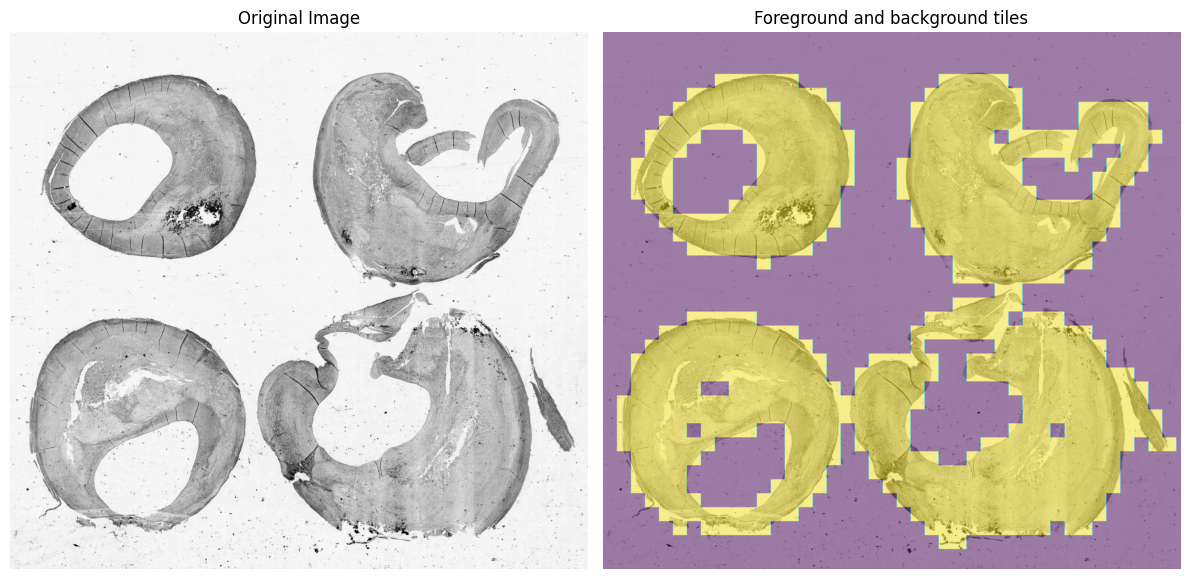

In [48]:
# Display the original image
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display the original image with foreground and background tiles
axes[1].imshow(image, cmap='gray')
axes[1].imshow(overlay, cmap='viridis', alpha=0.5)
axes[1].set_title('Foreground and background tiles')
axes[1].axis('off')

plt.tight_layout()
plt.show()

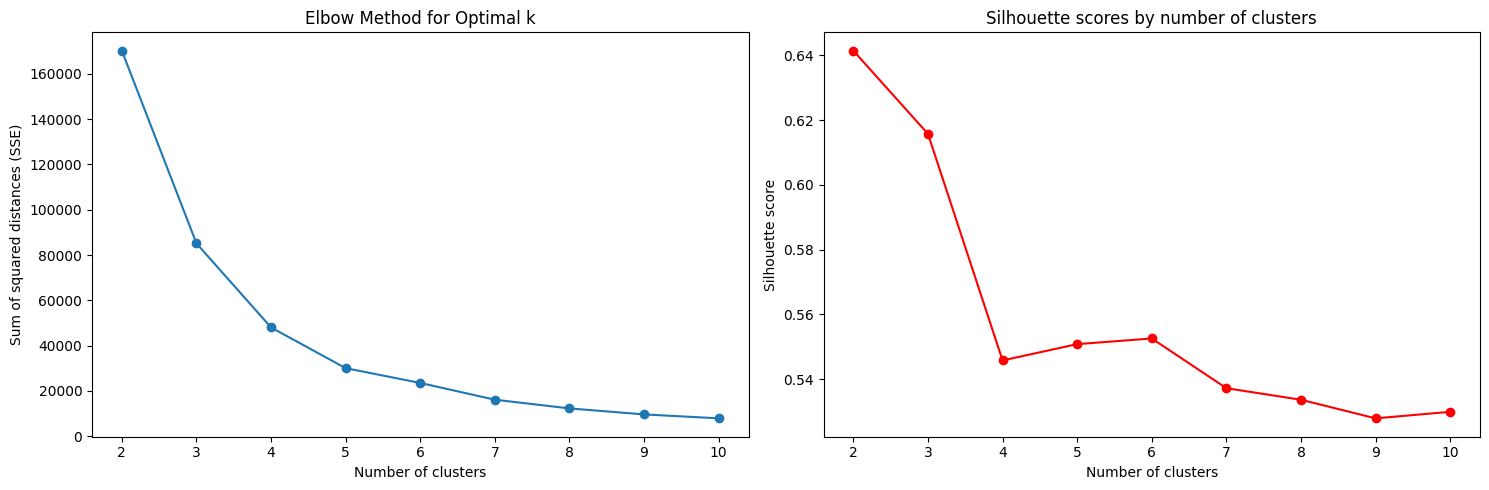

In [49]:
# Evaluate optimal number of clusters
determine_optimal_clusters(features)

In [50]:
# Optimal number of clusters
optimal_k = 4
cluster_labels = perform_kmeans(features, optimal_k)

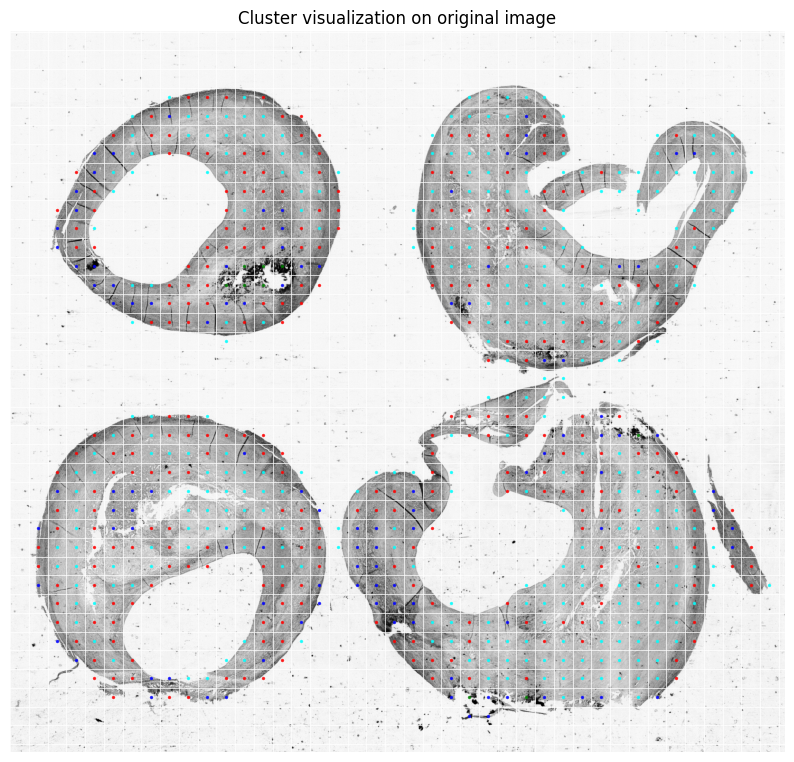

In [51]:
# Visualize clusters
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'orange', 'purple', 'olive']
visualize_clusters_with_grid(image, centers, cluster_labels, tile_size, colors)

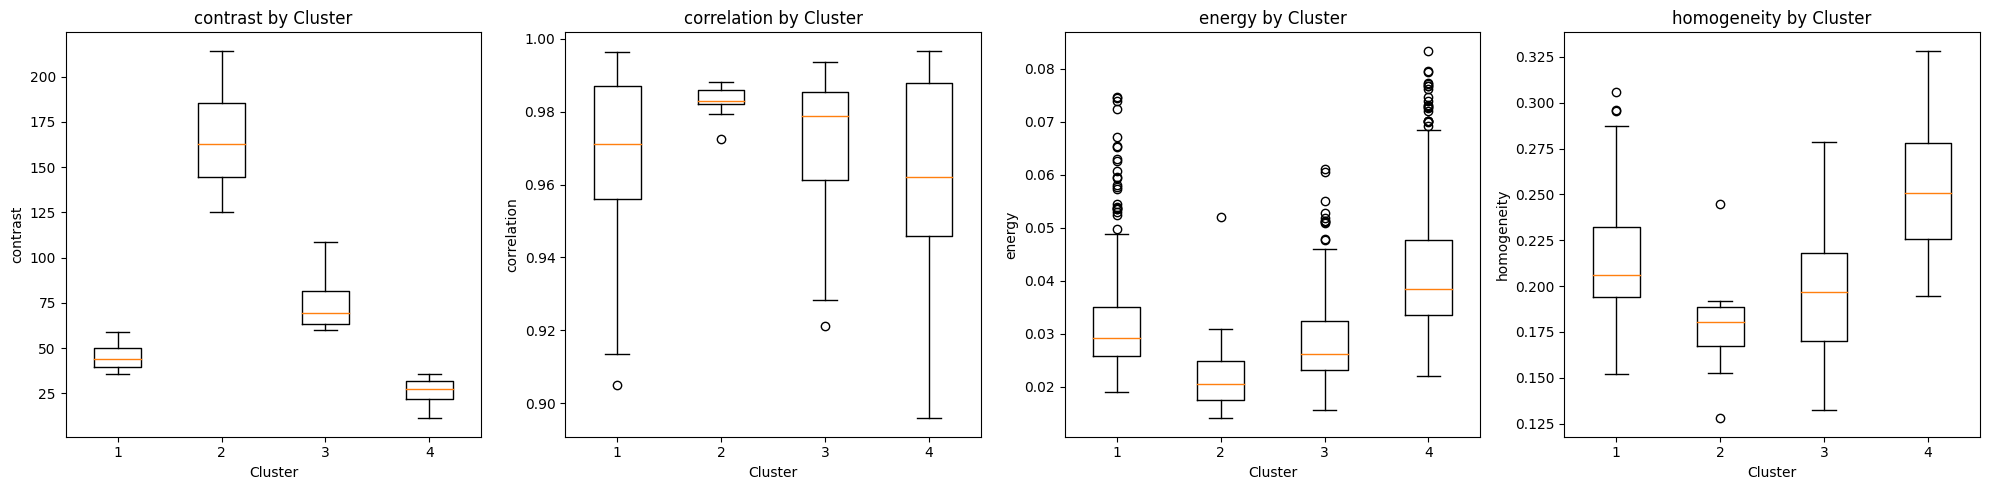

ANOVA for contrast: F-stat=1635.84, p-value=0.0000
ANOVA for correlation: F-stat=8.54, p-value=0.0000
ANOVA for energy: F-stat=55.44, p-value=0.0000
ANOVA for homogeneity: F-stat=137.79, p-value=0.0000


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from sklearn.cluster import KMeans

def plot_features_by_cluster(features, cluster_labels, feature_names):
    num_clusters = np.unique(cluster_labels).size
    num_features = features.shape[1]
    
    fig, axes = plt.subplots(1, num_features, figsize=(5 * num_features, 5))
    if num_features == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        data = [features[cluster_labels == k, i] for k in range(num_clusters)]
        ax.boxplot(data)
        ax.set_title(f'{feature_names[i]} by Cluster')
        ax.set_xlabel('Cluster')
        ax.set_ylabel(f'{feature_names[i]}')
        ax.set_xticks(range(1, num_clusters + 1))
        ax.set_xticklabels(range(1, num_clusters + 1))

    plt.tight_layout()
    plt.show()

    # Perform ANOVA
    for i, feature_name in enumerate(feature_names):
        data = [features[cluster_labels == k, i] for k in range(num_clusters)]
        f_stat, p_value = f_oneway(*data)
        print(f"ANOVA for {feature_name}: F-stat={f_stat:.2f}, p-value={p_value:.4f}")

feature_names = ['contrast', 'correlation', 'energy', 'homogeneity']
plot_features_by_cluster(features, cluster_labels, feature_names)


In [53]:
# pip install ptitprince

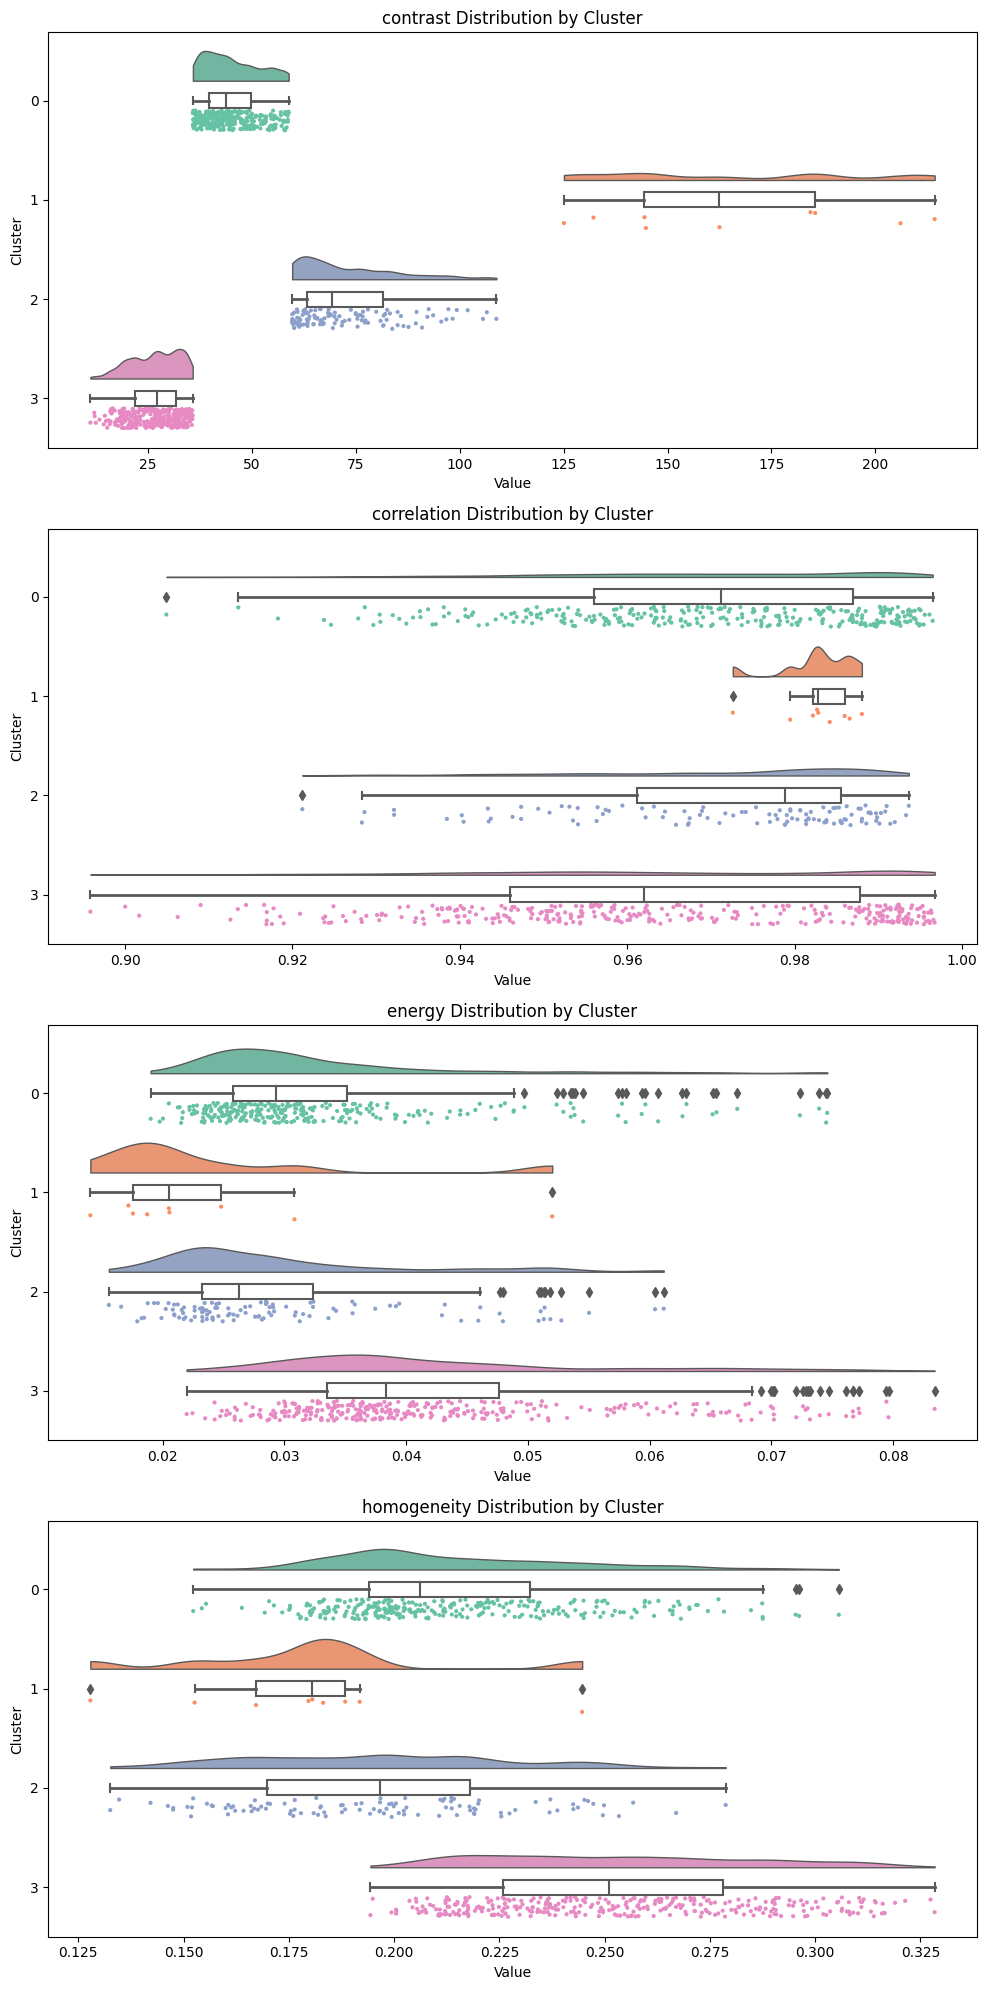

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt

def raincloud_plots(features, cluster_labels, feature_names):
    import pandas as pd
    df = pd.DataFrame(features, columns=feature_names)
    df['Cluster'] = cluster_labels

    fig, axes = plt.subplots(len(feature_names), 1, figsize=(10, 5 * len(feature_names)))
    if len(feature_names) == 1:
        axes = [axes]

    for i, feature in enumerate(feature_names):
        ax = axes[i]
        pt.RainCloud(data=df, x='Cluster', y=feature, palette="Set2", bw=.2, width_viol=.6,
                     ax=ax, orient='h', move=.2)
        ax.set_title(f'{feature} Distribution by Cluster')
        ax.set_xlabel('Value')
        ax.set_ylabel('Cluster')

    plt.tight_layout()
    plt.show()

raincloud_plots(features, cluster_labels, ['contrast', 'correlation', 'energy', 'homogeneity'])


In [55]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

db_index = davies_bouldin_score(features, cluster_labels)
print(f"Davies-Bouldin Index for {optimal_k} clusters: {db_index:.2f}")

Davies-Bouldin Index for 4 clusters: 0.52


In [56]:
best_k = None
lowest_dbi = float('inf')

for k in range(2, 11):  
    cluster_labels = perform_kmeans(features, k)
    current_dbi = davies_bouldin_score(features, cluster_labels)
    ch_index = calinski_harabasz_score(features, cluster_labels)  
    print(f"DBI: {current_dbi} with k: {k:.2f}")
    print(f"Calinski-Harabasz: {ch_index} with k: {k:.2f}")
    if current_dbi < lowest_dbi:
        lowest_dbi = current_dbi
        best_k = k

print(f"Optimal number of clusters based on DBI: {best_k} with a DBI of {lowest_dbi:.2f}")


DBI: 0.6129440831473235 with k: 2.00
Calinski-Harabasz: 867.0060681853566 with k: 2.00
DBI: 0.5006443157568943 with k: 3.00
Calinski-Harabasz: 1228.2781141899181 with k: 3.00
DBI: 0.5226095540624164 with k: 4.00
Calinski-Harabasz: 1635.807691892039 with k: 4.00
DBI: 0.5024077802641529 with k: 5.00
Calinski-Harabasz: 2065.5570288842237 with k: 5.00
DBI: 0.4872455817905775 with k: 6.00
Calinski-Harabasz: 2147.937499999449 with k: 6.00
DBI: 0.4915249768113505 with k: 7.00
Calinski-Harabasz: 2661.5654723865505 with k: 7.00
DBI: 0.4926307100462073 with k: 8.00
Calinski-Harabasz: 3021.076636738481 with k: 8.00
DBI: 0.4990600462218221 with k: 9.00
Calinski-Harabasz: 3391.925413708288 with k: 9.00
DBI: 0.49916990086810625 with k: 10.00
Calinski-Harabasz: 3685.9692616691323 with k: 10.00
Optimal number of clusters based on DBI: 6 with a DBI of 0.49


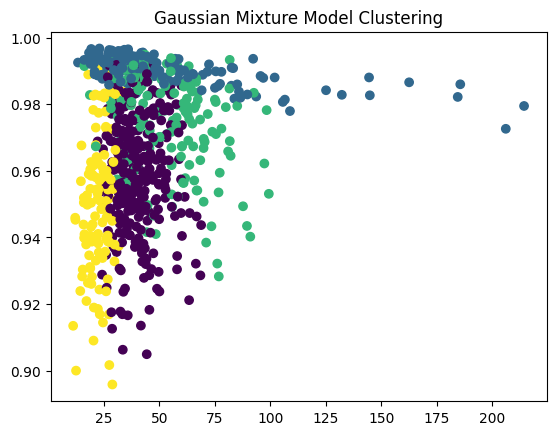

In [57]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm.fit_predict(features)

plt.scatter(features[:, 0], features[:, 1], c=gmm_labels, cmap='viridis')
plt.title('Gaussian Mixture Model Clustering')
plt.show()


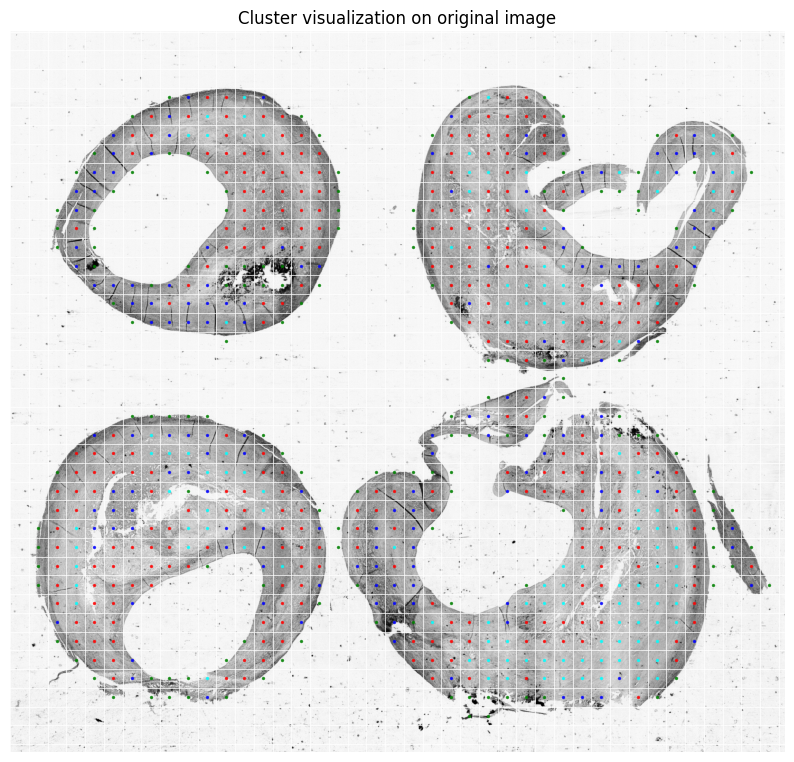

In [58]:
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'orange', 'purple', 'olive']
visualize_clusters_with_grid(image, centers, gmm_labels, tile_size, colors)

In [59]:
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# k-means
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(features_scaled)

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm.fit_predict(features_scaled)

In [60]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Adjusted Rand Index
ari_score = adjusted_rand_score(kmeans_labels, gmm_labels)
print(f'Adjusted Rand Index: {ari_score:.3f}')

# Normalized Mutual Information
nmi_score = normalized_mutual_info_score(kmeans_labels, gmm_labels)
print(f'Normalized Mutual Information: {nmi_score:.3f}')


Adjusted Rand Index: 0.264
Normalized Mutual Information: 0.359


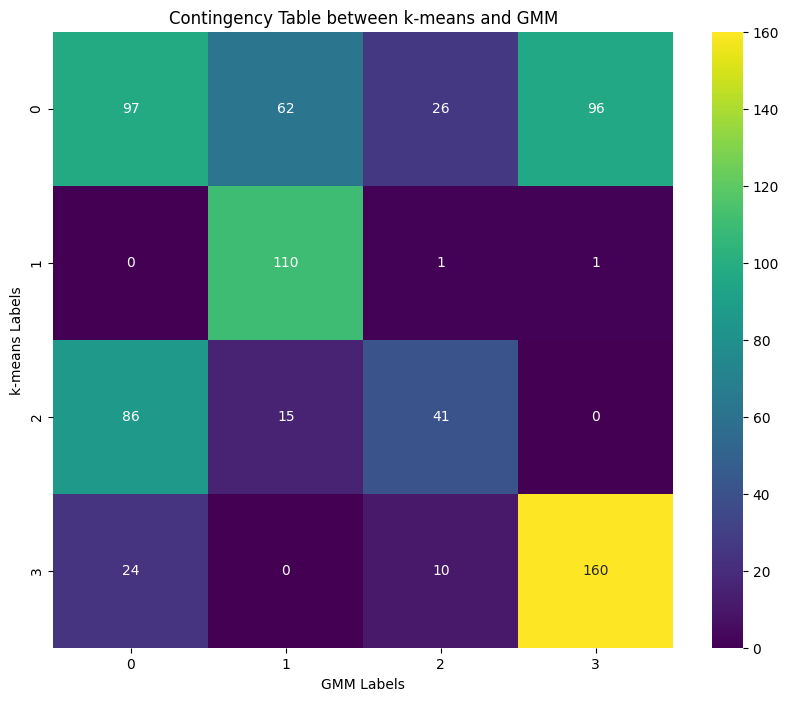

    0    1   2    3
0  97   62  26   96
1   0  110   1    1
2  86   15  41    0
3  24    0  10  160


In [61]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Contingency table
contingency_matrix = confusion_matrix(kmeans_labels, gmm_labels)

# Visualize the contingency table
plt.figure(figsize=(10, 8))
sns.heatmap(contingency_matrix, annot=True, fmt='d', cmap='viridis')
plt.xlabel('GMM Labels')
plt.ylabel('k-means Labels')
plt.title('Contingency table between k-means and GMM')
plt.show()

# Contingency table
print(pd.DataFrame(contingency_matrix))


In [62]:
# Number of differently classified tiles
num_different = np.sum(kmeans_labels != gmm_labels)
print(f'Number of differently classified tiles: {num_different}')


Number of differently classified tiles: 321


In [63]:
sse = []
max_k = 6
silhouette_scores = []
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features)
    sse.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(features, labels)
    silhouette_scores.append(silhouette_avg)

In [64]:
print(silhouette_scores)

[0.6414491166542855, 0.6157596805910579, 0.5457609228372952, 0.5507988567845878, 0.5525493222027696]
